In [1]:
# the library used
import numpy as np
import pandas as pd
import pysubgroup as ps
import re
from sklearn.feature_extraction import DictVectorizer
import time
import ast
import string 
import imblearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import functions
import rbo
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Who eats which ingredients

### Prepare for the data

In [3]:
data = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/food__drink_data.csv")

# extract the recipe id from recipe urls
list_cat_no = []
i = 0
for item in data['recipe_url']:
    list_cat_no.append(item.split('/')[4])
    
# add one column "recipe_id" into the dataset and set it as the index of dataset
data['recipe_id'] = list_cat_no
data = data.set_index(["recipe_id"])

# extract the numerical value string in the column calorie 
pat = r"([-+]?\d*\.\d+|\d+)"
data["calorie_value"] = data["calorie"].str.extract(pat, flags=0, expand=True)

# drop all rows with nan value in both columns comment_user and calorie_value
data_com = data.dropna(subset=["comment_user",'calorie_value'])
len(data_com)

19536

In [4]:
# expand the corresponding recipe data for each comment_user
df_com_1 = functions.extract_com_user(data_com)
df_com_2 = functions.sub_cat_in_com(data_com)
df_com_3 = functions.add_recipe_info(data_com)
df_com_new = df_com_1.merge(df_com_2, on='recipe_id', how='left')
df_com_new = df_com_new.merge(df_com_3, on='recipe_id', how='left')

df_com_new = df_com_new[['recipe_id','recipe_name','tags','difficulty','preparation_time','ingredient','name','rating','sex','age','marriage_status','comment_time','calorie_value']]
df_com_new = df_com_new.set_index(["recipe_id"])

# remove none value in the whole data set 
df_com_no_none = df_com_new.mask(df_com_new.astype(object).eq('None')).dropna()
df_com_no_none = df_com_no_none.reset_index()


# calculate and add calorie level , preparation time and age group columns in the comment user information
df_com_no_none["pretime_value"] = df_com_no_none["preparation_time"].str.extract(pat, flags=0, expand=True)
df_com_no_none['pre_time_group'] = df_com_no_none['pretime_value'].apply(functions.pre_time_group)

df_com_no_none['calorie_level'] = df_com_no_none['calorie_value'].apply(functions.calorie_level)
df_dum_calorie = pd.get_dummies(df_com_no_none['calorie_level'])

df_com_no_none["age_value"] = df_com_no_none["age"].str.extract(pat, flags=0, expand=True)
df_com_no_none['age_group'] = df_com_no_none['age_value'].apply(functions.age_group)

df_com_dum_calorie = df_com_no_none.join(df_dum_calorie, how='left')
df_sampling = df_com_dum_calorie[['rating','sex','age_group','marriage_status','calorie_level','pre_time_group','difficulty','tags','ingredient']]

### Most frequent 20 ingredients

In [4]:
import copy
downsampled_new = copy.deepcopy(df_com_dum_calorie)
downsampled_new = downsampled_new.reset_index()

# prepare the data for multi-class classifier
distinct_ingredients, df_2 = functions.ingredients_preprocess(downsampled_new)

In [311]:
df_temp = copy.deepcopy(df_2[['ingredient']])
df_temp['ingredient'] = df_temp['ingredient'].apply(tuple)

array([('nudelnmiereisnudelnoderreis', 'geflügelfleischgeschnetzelt', 'ananas', 'orangenoderblutorangen', 'cocktailtomaten', 'kokosmilch', 'sherry', 'kurkuma', 'chiliflocken', 'muskat', 'korianderpulver', 'cayennepfeffer', 'msp', 'safranpulver', 'zucker', 'salz'),
       ('kichererbsengekochte', 'nudelnvegane', 'salzwasser', 'frühlingszwiebeln', 'kurkuma', 'salzundpfefferkalanamaksalz'),
       ('wasser', 'agaragar', 'zucker', 'sirupfruchtsirupverschiedenesortennachwahl', 'vanilleextrakt', 'lebensmittelfarbe'),
       ...,
       ('eisbergsalat', 'schalotten', 'tomaten', 'mozzarellaevtlfettarm', 'tabasco'),
       ('weizenmehltype550', 'wasser', 'butterweiche', 'salz', 'hefefrisch', 'sesamoderanderekörnernachgeschmack'),
       ('eier', 'milch', 'zucker', 'vanilleschoten', 'speisestärke')],
      dtype=object)

In [314]:
ingredient = list(df_temp['ingredient'].unique())

In [321]:
from itertools import islice
def most_frequent_ingredient(data, num):
    count = {}
    for i in range(len(data)):
        # preprocessing the ingredient
        ingredients = list(data[i])
        
        # store the frequency in count dictionary
        for ingredient in ingredients:
            ingre_count = count.get(ingredient, 0) + 1
            count[ingredient] = ingre_count
    
    #sort the dictionary based on the count
    sorted_count = sorted(count.items(), key=lambda kv: -kv[1])
    num_items = list(islice(sorted_count, num))

    return num_items

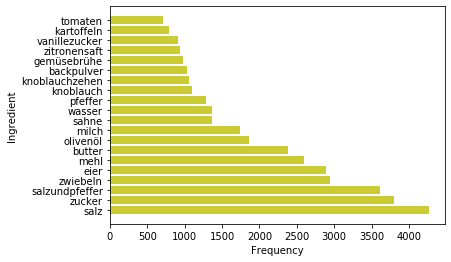

In [337]:
ingredients = pd.DataFrame(most_frequent_ingredient(ingredient, 20), columns = ['Ingredient', 'Frequency'])
plt.barh('Ingredient', 'Frequency', data = ingredients,color = 'y',alpha=0.8)
plt.xlabel("Frequency")
plt.ylabel("Ingredient")
#plt.title("The Most Common 20 Ingredient")
plt.show()

### Plot number of comment over time

refers to https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [442]:
comment_time = pd.to_datetime(df_com_dum_calorie['comment_time']).dt.date

In [443]:
df_time = pd.DataFrame(data = comment_time.value_counts().values,columns = ['num'])
df_time['date'] = comment_time.value_counts().index
df_time = df_time.sort_values(by=['date'])

In [444]:
df_time = df_time.set_index(pd.DatetimeIndex(df_time['date']))
#df_time.loc[start:end, 'num']

In [445]:
df_time_mean = df_time[['num']].resample('M').mean()
#df_time_mean.head(3)

In [446]:
df_time_week = df_time[['num']].resample('W').mean()

In [447]:
df_time = df_time.sort_values(by=['num'],ascending=False)
#df_time.head(30)

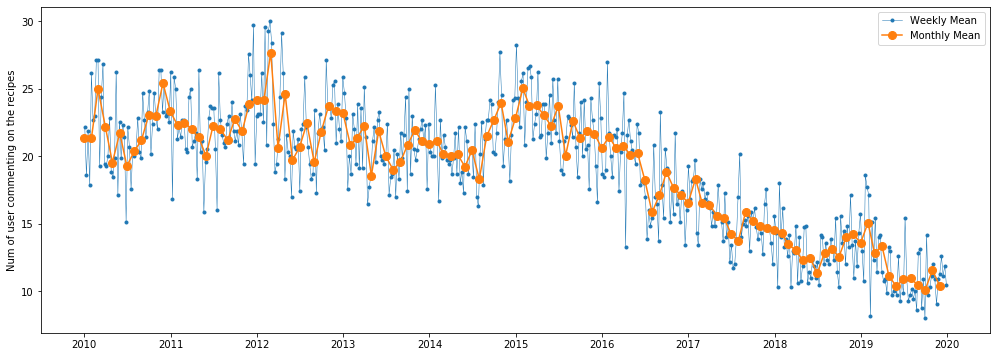

In [691]:
# Start and end of the date range to extract
start, end = '2009-12-30', '2019-12-30'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(17,6))
ax.plot(df_time_week.loc[start:end, 'num'],
marker='.', linestyle='-', linewidth=0.5, label='Weekly Mean')
ax.plot(df_time_mean.loc[start:end, 'num'],
marker='o', markersize=8, linestyle='-', label='Monthly Mean')
ax.set_ylabel('Num of user commenting on the recipes')
ax.legend();

### Pure Logistic Regression

In [5]:
# One hot encoding of the ingredients
df_2['ingredient'] = df_2.ingredient.apply(functions.convert_to_dict)
vectorizer = DictVectorizer(sparse=False)
new_df_2 = pd.DataFrame(data = vectorizer.fit_transform(df_2.ingredient.tolist()), columns = distinct_ingredients)
new_df_2[['sex', 'age_group', 'marriage_status', 'calorie_level']] = df_2[['sex', 'age_group', 'marriage_status', 'calorie_level']]

# set the target value by combining 'sex', 'age_group', 'marriage_status'
new_df_2['combine'] = new_df_2[['sex', 'age_group', 'marriage_status']].values.tolist()
new_df_2['combine'] = new_df_2['combine'].astype(str)

In [9]:
# multiclass classifer
clf_X = new_df_2.iloc[:, :-5]
y = new_df_2.iloc[:, -1]

clf = LogisticRegression(max_iter=1000)
clf.fit(clf_X, y)
y_pred = clf.predict(clf_X)

# accuracy 
print("Accuracy:",clf.score(clf_X, y))

Accuracy: 0.33531613111875996


In [21]:
from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(y, y_pred))

Accuracy: 0.33531613111875996


In [17]:
from sklearn.metrics import f1_score
# f1-score
print("F1-score:",f1_score(y, y_pred,average='weighted'))

F1-score: 0.2765202890943748


In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred)

array([[  0,   0,   0, ...,   1,   0,   0],
       [  0,  26,   5, ...,   8,   1,   0],
       [  0,   1,  80, ...,   9,   0,   0],
       ...,
       [  0,   2,   4, ..., 255,   3,   0],
       [  0,   1,   0, ...,  15,  29,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [215]:
df = pd.DataFrame()
for i in range(len(clf.classes_)):
    if clf.classes_[i] != 'overlap':
        df[clf.classes_[i]] = [vectorizer.feature_names_[ing_id] for ing_id in np.argsort(-clf.coef_[i])[:20]]

In [216]:
df

,"['männlich', '30-45 Jahre', 'Geschieden']","['männlich', '30-45 Jahre', 'Single']","['männlich', '30-45 Jahre', 'Vergeben']","['männlich', '30-45 Jahre', 'Verheiratet']","['männlich', '30-45 Jahre', 'Verwitwet']","['männlich', '45-60 Jahre', 'Geschieden']","['männlich', '45-60 Jahre', 'Single']","['männlich', '45-60 Jahre', 'Vergeben']","['männlich', '45-60 Jahre', 'Verheiratet']","['männlich', '45-60 Jahre', 'Verwitwet']",...,"['weiblich', '45-60 Jahre', 'Verwitwet']","['weiblich', '60+ Jahre', 'Geschieden']","['weiblich', '60+ Jahre', 'Single']","['weiblich', '60+ Jahre', 'Vergeben']","['weiblich', '60+ Jahre', 'Verheiratet']","['weiblich', '60+ Jahre', 'Verwitwet']","['weiblich', '<30 Jahre', 'Single']","['weiblich', '<30 Jahre', 'Vergeben']","['weiblich', '<30 Jahre', 'Verheiratet']","['weiblich', '<30 Jahre', 'Verwitwet']"
0,teefrüchteteezbkirschbananeaufgebrüht,pancettaoderbauchspeckgewürfelt,schokoladehalbbitter,pfifferlingeoderchampignonsgeschnitten,tortellonimitricottaspinatfüllungausdemkühlregal,sahnegeschlagen,hefeca42g,safranpulver,speckmagerer,petersilie,...,gewürze,hefefrische,rahmspinataufgetaut,milchziegenmindestens32fett,mehltype550,schokoladezartbittergrobgehackt,schokoladenachwahl,hefefrischeoder7gtrockenhefe,kondensmilchgezuckertezbmilchmädchen,hefefrisch
1,eiswürfel,speckinfeinenstreifenoderwürfeln,kartoffelnmöglichstgleichgroßeundmehligkochend,schweinefleischlachsbraten,sahneoderfettarmersahneersatz,chilischotenrot,ingwer,backpulverodertrockenhefe,schmalzzumfrittierenoderöl,stangenselleriefeingehackt,...,haferflockenzarte,zitronensaft,petersiliegetrocknet,apfelsäuerlichzbpinklady,wasserkaltesoder1ei,joghurtgriechischer,gnocchiausdemkühlregal,muskatnussfrischgerieben,puddingpulver,wasserfürdielauge
2,basilikummengenachgeschmack,sojasaucehelle,bierschwarzbierersatzweisepilsodermalzbier,kartoffelngroßundfestkochend,schmelzkäsefettarm,vanilleschotendasmark,goudamittelalter,schinkenluftgetrocknetzbparmaersatzweisefrühst...,lachsfiletstkoderfrisch,maniokyucageschältundstückegeschnitten,...,wirsing,natron,portwein,pellkartoffelnvomvortag,remoulade,kartoffelnkleinedrillinge,melonengaliamelonedasfruchtfleischabwiegen,schinkenroherkatenschinken,zitronenabgeriebeneschaledavon,salzgroboderfeinzumbestreuen
3,spaghettipenneconchiglienachwahl,eierbio,schokoladetoblerone,eiscrushedice,brokkoli,kartoffelnmehligegeschälte,tomateninscheiben,eierleichtverquirlt,portweinroter,zitronenspalten,...,zitronenpfeffer,knoblauchzehen,thunfischnaturell,milch15,kartoffelstärke,thunfischineigenemsaft,gewürzpastesüßerotebohnenpasteankoersatzweisen...,teigfürreibekuchenkühlregalalternativkloßteig,heidelbeerenfrische,margarinevegane
4,tomatenfrischereife,parmesanfrischgeriebener,paprikapulvergeräuchert,mehlundevtleinwenigstärkemehl,muskat,apfelinkleinenstücken,majorangerebbelt,honigmelonen,saftausdermandarinendose,tintenfischeküchenfertig,...,korianderpulver,puderzucker50gbuntezuckerstreusel,pfefferschwarzfrischgemahlen,zitronenabgeriebeneschaleunbehandelt,pflaumenoderzwetschgen,petersilieoderschnittlauch,avocadosreife,milch35fett,walnüssegemahlene,vollkornweizenmehl
5,oreganoalternativmajoran,bratwürstenürnberger,champignonsbraun,bohnengrünestangenbohnen,gemüsebrühe,zitronensaftund1pktcitroback,toastbrotweißbrot,tomaten400g,handkäse,knoblauchzehen,...,brennnesselndiejungenblätter,mehltype550oder405,zwiebelnrote,zitronenschaleabgerieben,kuvertüredunkle,mineralwassersprudel,naturjoghurtfettarm150g,schokoladebittere,kartoffelnvorwiegendfestkochendodermehlig,weizenmehlvollkorn
6,bacongewürfelt,brötchenhamburgerbrötchen,mehl405ambestenbackmehl,huhnhühnerfleischinstücken,olivenöl,zitronenunbehandeltoder,parmesanfrischgehobelt,eiervomhuhnweißoderbraun,gemüsegemischterbsenundmöhren,olivenölzumfrittieren,...,weinbrand,joghurttürkischensüzme,mais,hirse,kondensmilchmilchmädchengezuckerte,sardellenfilets,kräuterfrischenachbeliebenschnittlauchpetersil...,quinoa,eiswasser,vanillezuckerzumwenden
7,kartoffelngeviertelt,kekseamarettinis,kräuterlingezums

### Rank-bias Method to compare similarity
- package refers to https://github.com/dlukes/rbo/blob/master/README.md

In [23]:
data = []
for i in range(1,len(list(df.columns))):
    temp = []
    for j in range(1,len(list(df.columns))):
        if i == j:
            temp.append(np.nan)
        if i != j:
            temp.append(rbo.rbo(list(df.iloc[:,i]), list(df.iloc[:,j]), p=.9)[0])
    data.append(temp)

In [24]:
df_rbp = pd.DataFrame(data = data, columns = list(df.columns)[1:], index = list(df.columns)[1:])

In [25]:
def most_similar(df_rbp, subgroup):
    col = subgroup
    return df_rbp[str(col)][df_rbp[str(col)]==df_rbp[str(col)].max()]

In [502]:
subgroup = ['männlich', '45-60 Jahre', 'Vergeben']
most_similar(df_rbp, subgroup)

['weiblich', '<30 Jahre', 'Single']    0.014641
Name: ['männlich', '45-60 Jahre', 'Vergeben'], dtype: float64

In [506]:
df_rbp

,"['männlich', '30-45 Jahre', 'Single']","['männlich', '30-45 Jahre', 'Vergeben']","['männlich', '30-45 Jahre', 'Verheiratet']","['männlich', '30-45 Jahre', 'Verwitwet']","['männlich', '45-60 Jahre', 'Geschieden']","['männlich', '45-60 Jahre', 'Single']","['männlich', '45-60 Jahre', 'Vergeben']","['männlich', '45-60 Jahre', 'Verheiratet']","['männlich', '45-60 Jahre', 'Verwitwet']","['männlich', '60+ Jahre', 'Geschieden']",...,"['weiblich', '45-60 Jahre', 'Verwitwet']","['weiblich', '60+ Jahre', 'Geschieden']","['weiblich', '60+ Jahre', 'Single']","['weiblich', '60+ Jahre', 'Vergeben']","['weiblich', '60+ Jahre', 'Verheiratet']","['weiblich', '60+ Jahre', 'Verwitwet']","['weiblich', '<30 Jahre', 'Single']","['weiblich', '<30 Jahre', 'Vergeben']","['weiblich', '<30 Jahre', 'Verheiratet']","['weiblich', '<30 Jahre', 'Verwitwet']"
"['männlich', '30-45 Jahre', 'Single']",NaN,2.635526e-09,1.039256e-10,0.000000e+00,1.840538e-04,7.479262e-06,1.923229e-03,6.471189e-11,7.894919e-16,3.436145e-11,...,1.416112e-11,7.042823e-06,9.873397e-07,8.600409e-11,9.079157e-15,3.403287e-09,3.095496e-06,8.932691e-10,4.021506e-02,1.578984e-15
"['männlich', '30-45 Jahre', 'Vergeben']",2.635526e-09,NaN,3.038003e-09,0.000000e+00,1.819950e-05,7.677350e-07,1.804929e-10,9.165626e-03,1.369640e-06,3.120347e-04,...,1.470468e-08,5.378939e-05,8.795623e-07,2.939199e-05,7.227506e-09,4.374534e-05,1.726621e-06,1.456106e-03,1.092123e-07,0.000000e+00
"['männlich', '30-45 Jahre', 'Verheiratet']",1.039256e-10,3.038003e-09,NaN,1.840528e-04,1.133308e-07,3.700583e-09,5.180330e-11,1.538285e-06,2.168734e-12,2.763222e-15,...,1.225849e-07,1.651259e-03,1.443581e-03,3.019807e-12,2.042639e-02,1.588436e-08,7.381750e-14,3.047188e-04,1.294767e-13,1.202167e-09
"['männlich', '30-45 Jahre', 'Verwitwet']",0.000000e+00,0.000000e+00,1.840528e-04,NaN,1.267911e-08,0.000000e+00,0.000000e+00,0.000000e+00,2.435438e-02,3.479683e-06,...,1.884912e-14,1.467870e-05,7.687395e-10,0.000000e+00,5.564354e-06,0.000000e+00,2.647759e-12,5.471614e-07,2.861908e-15,4.279931e-03
"['männlich', '45-60 Jahre', 'Geschieden']",1.840538e-04,1.819950e-05,1.133308e-07,1.267911e-08,NaN,2.232780e-09,3.342441e-05,6.674602e-11,9.055275e-05,2.481078e-06,...,4.052026e-06,2.391178e-03,2.724279e-06,7.471597e-07,5.757335e-04,1.112459e-02,3.441077e-08,1.009619e-05,3.846259e-07,2.763198e-04
"['männlich', '45-60 Jahre', 'Single']",7.479262e-06,7.677350e-07,3.700583e-09,0.000000e+00,2.232780e-09,NaN,8.943210e-05,2.485739e-03,1.840529e-04,1.107136e-07,...,1.012649e-03,3.961181e-08,4.170557e-09,2.606544e-05,4.106272e-08,3.370842e-03,7.841405e-03,1.226905e-07,4.399645e-06,0.000000e+00
"['männlich', '45-60 Jahre', 'Vergeben']",1.923229e-03,1.804929e-10,5.180330e-11,0.000000e+00,3.342441e-05,8.943210e-05,NaN,1.625250e-04,3.420158e-11,5.825079e-03,...,3.224717e-07,0.000000e+00,3.542495e-05,8.689261e-04,9.693665e-04,2.634456e-11,1.464150e-02,3.780548e-03,3.944456e-10,3.061452e-11
"['männlich', '45-60 Jahre', 'Verheiratet']",6.471189e-11,9.165626e-03,1.538285e-06,0.000000e+00,6.674602e-11,2.485739e-03,1.625250e-04,NaN,0.000000e+00,1.075754e-10,...,2.400462e-04,3.919571e-04,5.757918e-04,1.880451e-11,2.485739e-03,8.408089e-14,2.486900e-14,3.697792e-09,8.617615e-07,4.901166e-12
"['männlich', '45-60 Jahre', 'Verwitwet']",7.894919e-16,1.369640e-06,2.168734e-12,2.435438e-02,9.055275e-05,1.840529e-04,3.420158e-11,0.000000e+00,NaN,1.445844e-03,...,2.488479e-11,5.322511e-02,4.673792e-13,3.060307e-04,3.877803e-07,8.238506e-11,3.919571e-04,6.469886e-13,1.578984e-15,2.472144e-03
"['männlich', '60+ Jahre', 'Geschieden']",3.436145e-11,3.120347e-04,2.763222e-15,3.479683e-06,2.481078e-06,1.107136e-07,5.825079e-03,1.075754e-10,1.445844e-03,NaN,...,6.908068e-05,7.005435e-05,7.460907e-04,1.120889e-04,2.859978e-03,1.737296e-06,4.328557e-09,1.578984e-15,2.430059e-02,9.147048e-08


### Visualize similarity

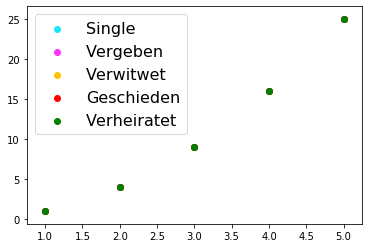

<Figure size 7200x36000 with 0 Axes>

In [845]:
import numpy as np 
import matplotlib.pyplot as plt 
  
# X-axis values 
x = [1, 2, 3, 4, 5] 
  
# Y-axis values  
y = [1, 4, 9, 16, 25] 
  
# Function to plot   
plt.scatter(x, y,color = "#1CE6FF") 
plt.scatter(x, y,color = "#FF34FF") 
plt.scatter(x, y,color = "#FFC300") 
plt.scatter(x, y,color = "red") 
plt.scatter(x, y,color = "green") 
  
# Function add a legend   
plt.legend(['Single',"Vergeben","Verwitwet","Geschieden",'Verheiratet'],prop={'size': 16}) 
plt.figure(figsize=(100,500)) 
plt.show() 

In [760]:
mapping = {"['männlich', '30-45 Jahre', 'Single']": "['männlich', '30-45 Jahre']", 
           "['männlich', '30-45 Jahre', 'Vergeben']":"['männlich', '30-45 Jahre']",
           "['männlich', '30-45 Jahre', 'Verheiratet']":"['männlich', '30-45 Jahre']",
           "['männlich', '30-45 Jahre', 'Verwitwet']": "['männlich', '30-45 Jahre']",
           "['männlich', '45-60 Jahre', 'Geschieden']": "['männlich', '45-60 Jahre']",
            "['männlich', '45-60 Jahre', 'Single']": "['männlich', '45-60 Jahre']",
           "['männlich', '45-60 Jahre', 'Vergeben']":"['männlich', '45-60 Jahre']",
           "['männlich', '45-60 Jahre', 'Verheiratet']": "['männlich', '45-60 Jahre']",
           "['männlich', '45-60 Jahre', 'Verwitwet']": "['männlich', '45-60 Jahre']",
            "['männlich', '60+ Jahre', 'Geschieden']":  "['männlich', '60+ Jahre']",
           "['männlich', '60+ Jahre', 'Single']":"['männlich', '60+ Jahre']",
           "['männlich', '60+ Jahre', 'Vergeben']":"['männlich', '60+ Jahre']",
           "['männlich', '60+ Jahre', 'Verheiratet']":"['männlich', '60+ Jahre']",
           "['männlich', '60+ Jahre', 'Verwitwet']":"['männlich', '60+ Jahre']",
            "['männlich', '<30 Jahre', 'Single']":"['männlich', '<30 Jahre']",
           "['männlich', '<30 Jahre', 'Vergeben']": "['männlich', '<30 Jahre']",
           "['männlich', '<30 Jahre', 'Verheiratet']":"['männlich', '<30 Jahre']",
           "['weiblich', '30-45 Jahre', 'Geschieden']":"['weiblich', '30-45 Jahre']",
           "['weiblich', '30-45 Jahre', 'Single']":"['weiblich', '30-45 Jahre']",
           "['weiblich', '30-45 Jahre', 'Vergeben']":"['weiblich', '30-45 Jahre']",
           "['weiblich', '30-45 Jahre', 'Verheiratet']":"['weiblich', '30-45 Jahre']",
           "['weiblich', '30-45 Jahre', 'Verwitwet']":"['weiblich', '30-45 Jahre']",
           "['weiblich', '45-60 Jahre', 'Geschieden']":"['weiblich', '45-60 Jahre']",
           "['weiblich', '45-60 Jahre', 'Single']":"['weiblich', '45-60 Jahre']",
           "['weiblich', '45-60 Jahre', 'Vergeben']":"['weiblich', '45-60 Jahre']",
           "['weiblich', '45-60 Jahre', 'Verheiratet']":"['weiblich', '45-60 Jahre']",
           "['weiblich', '45-60 Jahre', 'Verwitwet']":"['weiblich', '45-60 Jahre']",
           "['weiblich', '60+ Jahre', 'Geschieden']":"['weiblich', '60+ Jahre']",
           "['weiblich', '60+ Jahre', 'Single']":"['weiblich', '60+ Jahre']",
           "['weiblich', '60+ Jahre', 'Vergeben']":"['weiblich', '60+ Jahre']",
           "['weiblich', '60+ Jahre', 'Verheiratet']":"['weiblich', '60+ Jahre']",
           "['weiblich', '60+ Jahre', 'Verwitwet']":"['weiblich', '60+ Jahre']",
            "['weiblich', '<30 Jahre', 'Single']":"['weiblich', '<30 Jahre']",
           "['weiblich', '<30 Jahre', 'Vergeben']":"['weiblich', '<30 Jahre']",
           "['weiblich', '<30 Jahre', 'Verheiratet']":"['weiblich', '<30 Jahre']",
           "['weiblich', '<30 Jahre', 'Verwitwet']":"['weiblich', '<30 Jahre']"}

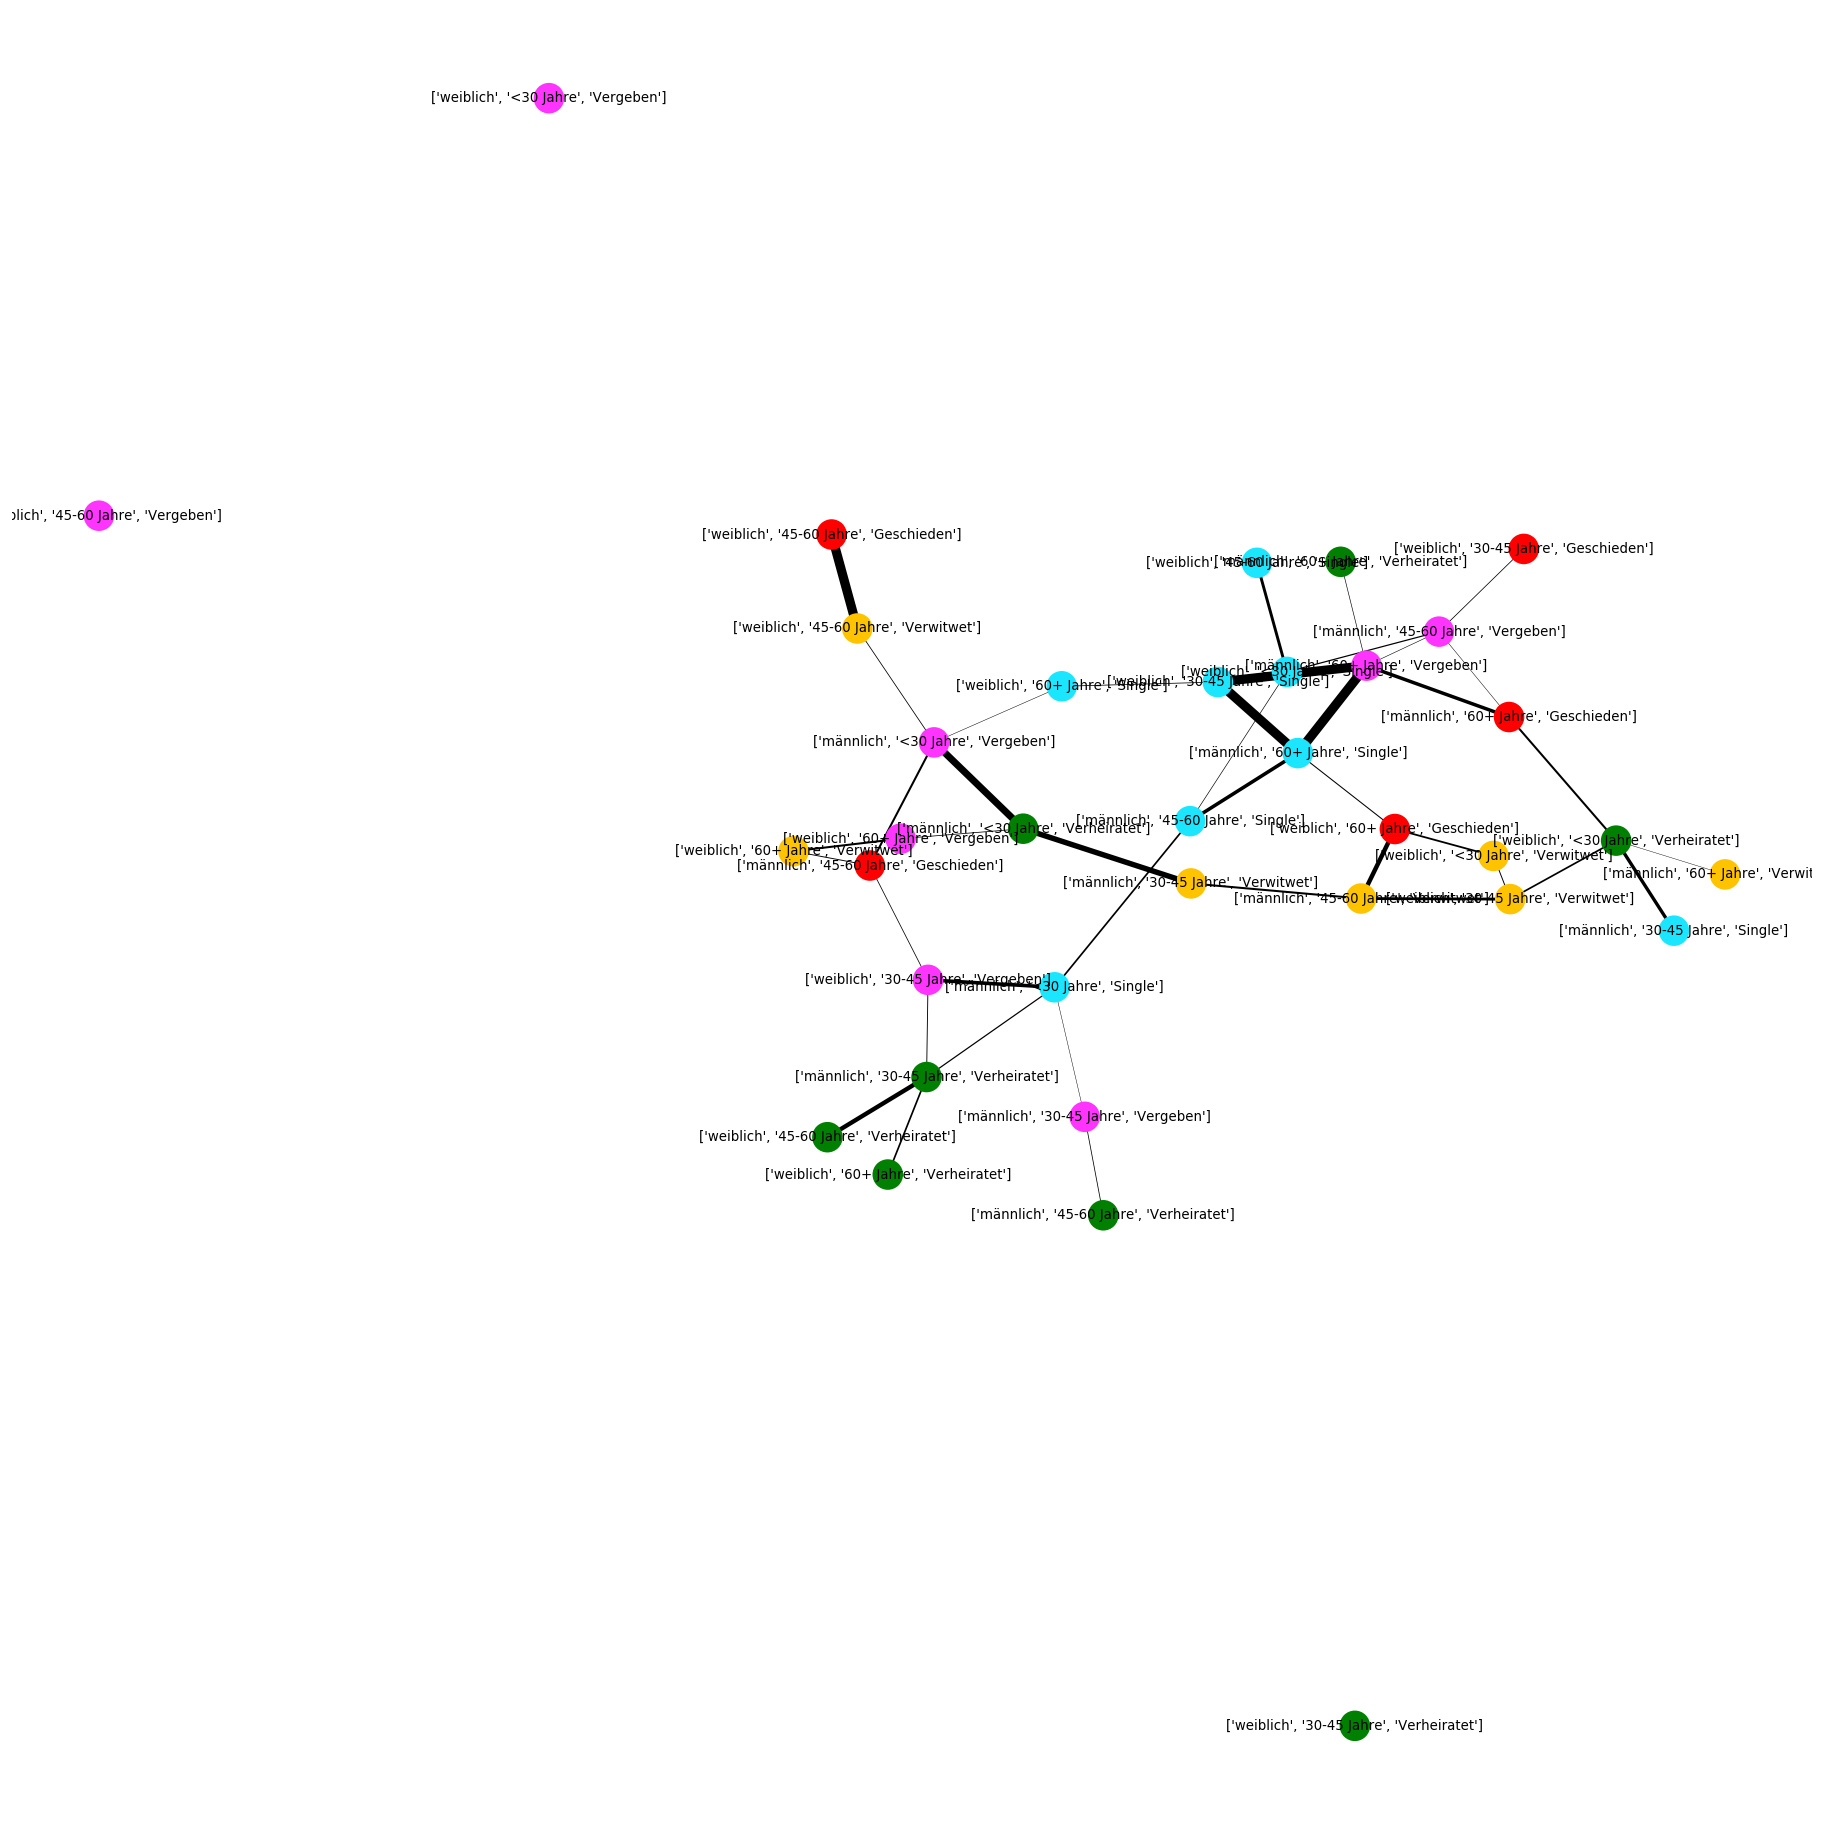

In [806]:
import networkx as nx
labels = list(df_rbp.index)
G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_nodes_from(labels)

edges = []
edge_width = []
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        if df_rbp.iloc[i][j]>0.005:
            edges.append([labels[i],labels[j]])
            edge_width.append(df_rbp.iloc[i][j]*50)
G.add_edges_from(edges)

color_map = []
for node in G:
    if "Single" in node:
        color_map.append("#1CE6FF")
    if "Vergeben" in node:
        color_map.append("#FF34FF")
    if "Verwitwet" in node:
        color_map.append("#FFC300")
    if "Geschieden" in node:
        color_map.append("red")
    if "Verheiratet" in node:
        color_map.append("green")
        

        
#mapping = {"['männlich', '60+ Jahre', 'Verheiratet']": "['männlich', '60+ Jahre']", 1: 'b', 2: 'c'}
H = nx.relabel_nodes(G, mapping)

figure(num=None, figsize=(15, 15), dpi=120, facecolor='g')
nx.draw(G, with_labels=node_labels,node_color=color_map,width=edge_width, pos=nx.spring_layout(G),font_size=8) # use spring layout
plt.savefig("Graph.png", format="PNG")

### LDA + Logistic Regression

try LDA as input to Logistic regression, but does not make any improvement so we do not mention in the report
- https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [206]:
from sklearn.svm import LinearSVC

In [163]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

lda_data = df_sampling

# prepare the data for multi-class classifier
ingredients_lda, df_lda = functions.ingredients_preprocess(lda_data)
recipe_ingredients = [l for l in df_lda['ingredient']]

# Create a corpus from a list of texts
lda_dictionary = Dictionary(recipe_ingredients)
lda_corpus = [lda_dictionary.doc2bow(text) for text in recipe_ingredients]

In [218]:
num_topics = 1000

# train lda model
lda_model = gensim.models.LdaMulticore(lda_corpus, num_topics=num_topics, id2word=lda_dictionary, passes=2, workers=2)

/Users/xujingjing/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [219]:
train_vecs = []
for i in range(len(lda_corpus)):
    top_topics = lda_model.get_document_topics(lda_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    train_vecs.append(topic_vec)

In [220]:
# set the topic distribtion as X
lda_X = train_vecs

# set the target value by combining 'sex', 'age_group', 'marriage_status'
lda_data['combine'] = lda_data[['sex', 'age_group', 'marriage_status']].values.tolist()
lda_data['combine'] = lda_data['combine'].astype(str)
lda_y = lda_data['combine']

/Users/xujingjing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/xujingjing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [221]:
from sklearn.linear_model import SGDClassifier
lda_clf = SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(lda_X, lda_y)

In [222]:
# multiclass classifer
#lda_clf = LogisticRegression(max_iter=1000)
lda_clf = LinearSVC()
lda_clf.fit(lda_X, lda_y)
lda_y_pred = lda_clf.predict(lda_X)

In [223]:
from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(lda_y, lda_y_pred))

Accuracy: 0.2341703435052785


In [224]:
print("F1-score:",f1_score(lda_y, lda_y_pred,average='weighted'))

F1-score: 0.08886253030782797


In [ ]:
top_topics = lda_model.get_document_topics(lda_corpus[20], minimum_probability=0.0)

In [182]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.178*"zuckerbraun" + 0.107*"kirschtomaten" + 0.088*"butter" + 0.085*"weinweiß" + 0.065*"salz" + 0.051*"spargelgrün" + 0.050*"mehl" + 0.043*"wasserwarmes" + 0.040*"himbeerentk" + 0.033*"sellerie"
Topic: 1 
Words: 0.162*"rosinen" + 0.123*"butterodermargarine" + 0.079*"puderzuckerzumbestäuben" + 0.079*"linsenrote" + 0.077*"wirsing" + 0.065*"sauerrahm" + 0.037*"haselnüssegemahlen" + 0.037*"zucker" + 0.023*"eier" + 0.023*"milch"
Topic: 2 
Words: 0.158*"essig" + 0.128*"senf" + 0.103*"zucker" + 0.082*"salzundpfeffer" + 0.065*"salatgurken" + 0.061*"salz" + 0.061*"paniermehl" + 0.054*"zwiebeln" + 0.036*"brühegekörnte" + 0.032*"wasser"
Topic: 3 
Words: 0.139*"dill" + 0.080*"zitronensaft" + 0.068*"salzwasser" + 0.059*"gemüsebrühe" + 0.053*"salz" + 0.048*"salzundpfeffer" + 0.045*"thunfischimeigenensaft" + 0.039*"petersiliefeingehackt" + 0.037*"butter" + 0.035*"zwiebeln"
Topic: 4 
Words: 0.205*"frischkäse" + 0.152*"trockenhefe" + 0.089*"erbsentk" + 0.060*"zucker" + 0.043*"butter" 

### tsne plotting of differnt marriage status regarding to ingredients

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [16]:
columns = list(new_df_2.columns)
columns.remove('combine')
columns.remove('calorie_level')
columns.remove('age_group')
columns.remove('sex')
columns.remove('marriage_status')

X = new_df_2[columns]
y = new_df_2['marriage_status']

In [17]:
def computeIDF(clf_X):
    num_document = len(clf_X)
    idf_row = clf_X.sum(axis = 0, skipna = True) 
    idf_row = len(clf_X)/idf_row
    return idf_row

def computeTF(clf_X):
    clf_X['sum'] = clf_X.sum(axis = 1, skipna = True)
    clf_X = clf_X.div(clf_X['sum'], axis=0)
    clf_X = clf_X.drop(['sum'],axis = 1)
    return clf_X

In [18]:
idf_row = computeIDF(X)
X = computeTF(X)
X = X*idf_row
X = X.fillna(0)

/Users/xujingjing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
# first use PCA to reduce the dimension to 500 
pca_1000 = PCA(n_components=1000)
pca_result_1000 = pca_1000.fit_transform(X)
print('Cumulative explained variation for 1000 principal components: {}'.format(np.sum(pca_1000.explained_variance_ratio_)))

Cumulative explained variation for 1000 principal components: 0.572615541204877


In [22]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_1000)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 2941.8746309280396 seconds


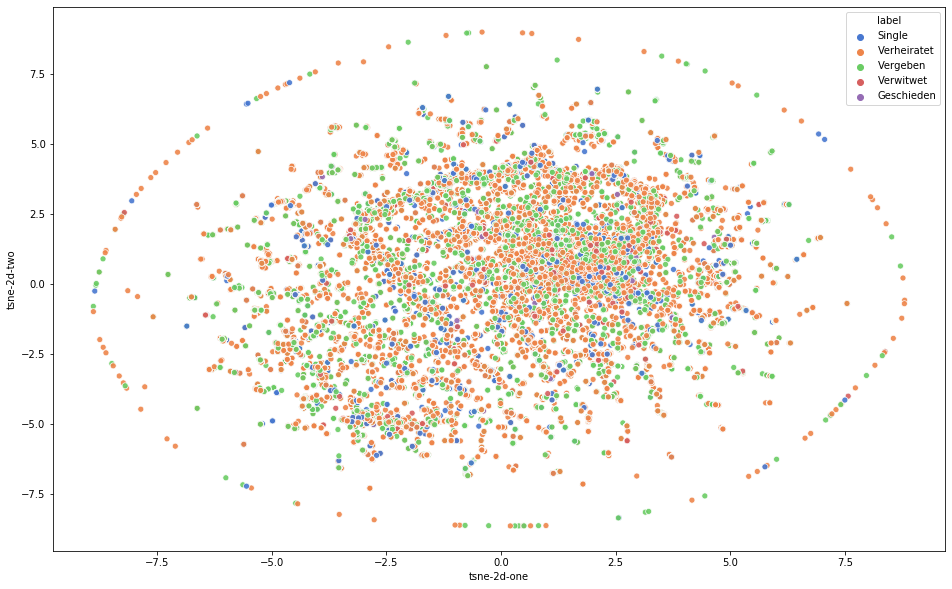

In [24]:
plt_data = pd.DataFrame()
plt_data['label'] = y
plt_data['tsne-2d-one'] = tsne_pca_results[:,0]
plt_data['tsne-2d-two'] = tsne_pca_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("muted", 5),
    data=plt_data,
    legend="full",
    alpha=0.9
)

### Word2vec plot the embedding for subgroups
- https://www.kaggle.com/arunava21/word2vec-with-ingredients
- https://towardsdatascience.com/building-a-food-recommendation-system-90788f78691a

In [230]:
sentences = []
for i in range(len(recipe_ingredients)):
    sent = []
    subgroup = lda_y[i]
    for j in range(len(recipe_ingredients[i])):
        if j==0:
            sent.append(subgroup)
        sent.append(recipe_ingredients[i][j])
        sent.append(subgroup)
    sentences.append(sent)

In [243]:
import gensim
from gensim.models import Word2Vec
w2v_model = Word2Vec(size=50, sample=0.000009, alpha=0.05, min_alpha=0.005, min_count=1, workers = 3, window=4)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)
len(w2v_model.wv.vocab)

18550

/Users/xujingjing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


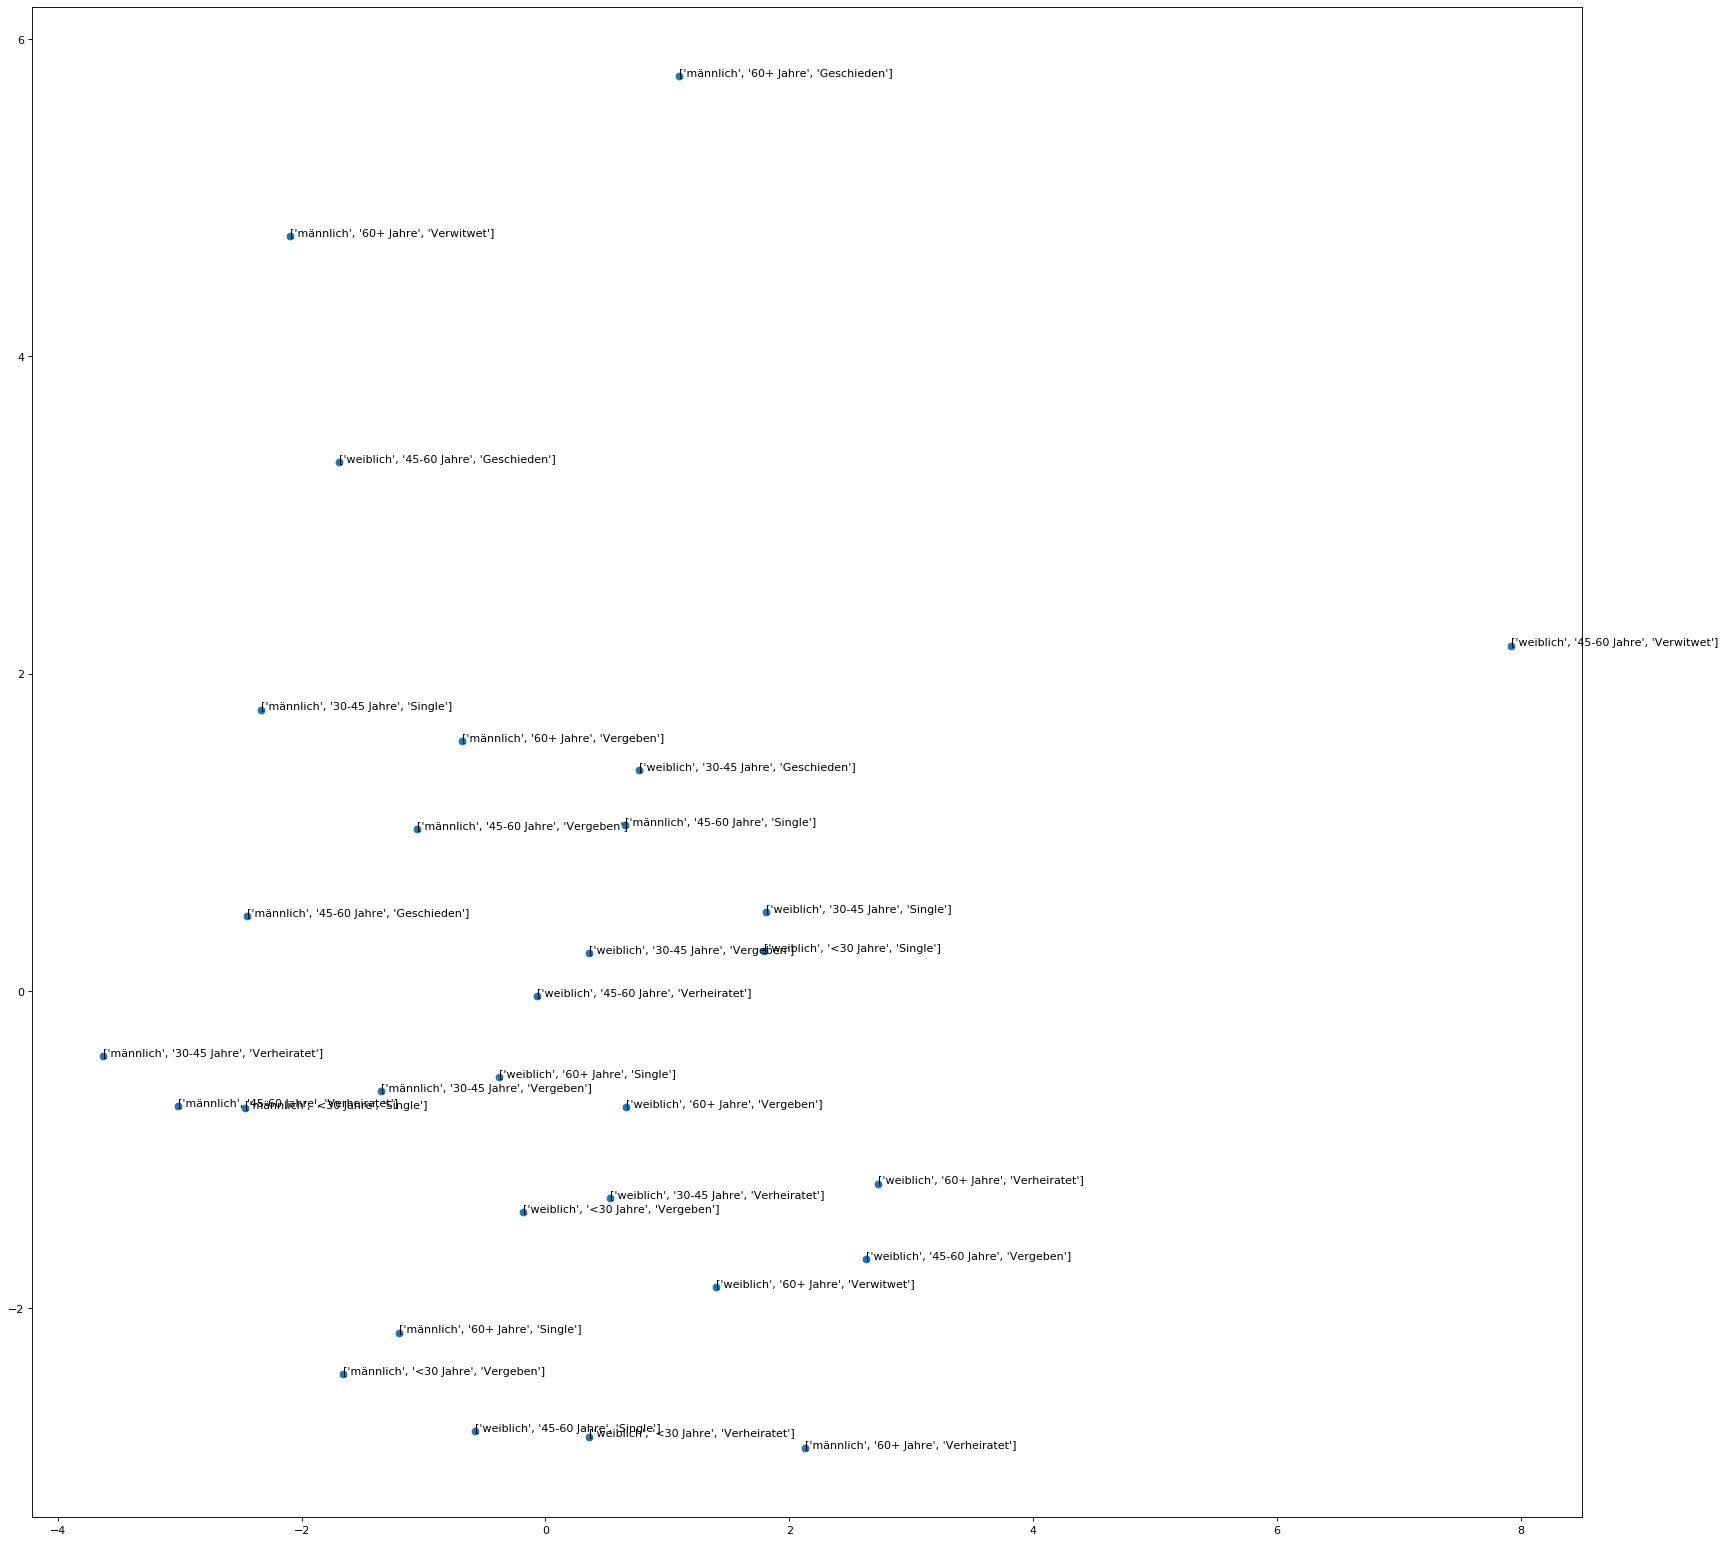

In [262]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

words = list(lda_y.value_counts().index)[:30]
vectors = [w2v_model[word] for word in words]

from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 25), dpi=80, facecolor='w', edgecolor='k')

#tsne = TSNE(n_components=2, random_state=0)
#Y = tsne.fit_transform(vectors)
pca = PCA(n_components = 2)
x = StandardScaler().fit_transform(vectors)
Y = pca.fit_transform(x)

plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")

### Notable Ingredients of different marriage status based on logistic regression

In [850]:
# multiclass classifer
y_new = new_df_2['marriage_status']
clf_new = LogisticRegression(max_iter=1000)
clf_new.fit(clf_X, y_new)
y_pred_new = clf_new.predict(clf_X)

# accuracy 
print("Accuracy:",clf_new.score(clf_X, y_new))

Accuracy: 0.586858093280048


In [855]:
df_new = pd.DataFrame()
for i in range(len(clf_new.classes_)):
    if clf_new.classes_[i] != 'overlap':
        df_new[clf_new.classes_[i]] = [vectorizer.feature_names_[ing_id] for ing_id in np.argsort(-clf_new.coef_[i])[:20]]

In [94]:
import copy
new_clf_X = copy.deepcopy(clf_X)

In [ ]:
index = []
for i in range(18514):
    if sum(new_clf_X.iloc[:,i]) < 5:
        index.append(i)

columns = list(new_clf_X.columns)
drop_columns = [columns[i] for i in index]

new_clf_X = new_clf_X.drop(columns=drop_columns)

In [ ]:
new_clf_X.shape

In [ ]:
def computeIDF(clf_X):
    num_document = len(clf_X)
    idf_row = clf_X.sum(axis = 0, skipna = True) 
    idf_row = len(clf_X)/idf_row
    return idf_row

def computeTF(clf_X):
    clf_X['sum'] = clf_X.sum(axis = 1, skipna = True)
    clf_X = clf_X.div(clf_X['sum'], axis=0)
    clf_X = clf_X.drop(['sum'],axis = 1)
    return clf_X

In [ ]:
# multiclass classifer
#clf_X = new_df_2.iloc[:, :-5]
idf_row = computeIDF(new_clf_X)
X = computeTF(new_clf_X)
X = X*idf_row
X = X.fillna(0)

In [ ]:
# multiclass classifer
y_new = new_df_2['marriage_status']
clf_new_2 = LogisticRegression(max_iter=1000)
clf_new_2.fit(X, y_new)
#y_pred_new = clf_new_2.predict(X)

# accuracy 
print("Accuracy:",clf_new_2.score(X, y_new))

In [ ]:
df_new = pd.DataFrame()
for i in range(len(clf_new_2.classes_)):
    if clf_new_2.classes_[i] != 'overlap':
        df_new[clf_new_2.classes_[i]] = [vectorizer.feature_names_[ing_id] for ing_id in np.argsort(-clf_new_2.coef_[i])[:20]]

In [ ]:
df_new

### Notable Ingredients of different marriage status based on TF-IDF

In [81]:
data_ingredient = X
data_ingredient['marriage_status'] = y_new

In [88]:
ingredients = list(data_ingredient.columns)

def get_dictionary(dictionary, data):
    for i in range(7300):
        dictionary[ingredients[i]] = sum(data.iloc[:,i])

In [89]:
# Verheiratet
data_verheitatet = data_ingredient[data_ingredient['marriage_status'] == 'Verheiratet']
dict_verheitatet = {}
get_dictionary(dict_verheitatet, data_verheitatet)

dictionary = {'chili schoten': 35760.47826086956,
 'kandierte kirschen': 34631.200000000004,
 'pumpernickel': 31897.157894736854,
 'vanille zucker': 31897.157894736854,
 'pudding pulver vanille geschmack': 26639.38461538462,
 'paprika schoten': 25973.399999999998,
 'gorgonzola oder käse': 21644.5,
 'schokolade': 21644.5,
 'toast brot': 21644.5,
 'rosenkohl': 19694.77718253968,
 'spinat': 18948.07531023392,
 'mandeln': 18851.661290322583,
 'butter': 18552.42857142857,
 'salz und pfeffer': 18226.94736842106,
 'schinken': 18226.94736842106,
 'thunfischinöl': 18037.083333333332,
 'hefe': 17709.136363636364,
 'kalbfleisch': 17315.6,
 'zitronen': 15460.357142857141,
 'sahne oder créme frâiche': 14984.65384615385}

In [131]:
# Single
data_single = data_ingredient[data_ingredient['marriage_status'] == 'Single']
dict_single = {}
get_dictionary(dict_single, data_single)
dictionary = {'nordseekrabben': 10822.25,
 'flank steak': 8657.8,
 'spaghetti': 8657.8,
 'paprika schoten': 8657.8,
 'brühe fette': 7214.833333333333,
 'schokolade': 7214.833333333333,
 'weißkohl oder chinakohl': 6926.24,
 'bundmöhren': 6012.361111111111,
 'flusskrebsfleisch': 5497.015873015873,
 'schmelzkäse': 5194.68,
 'soja milch': 5194.68,
 'gelee quitte': 5050.383333333334,
 'kekse': 5050.383333333334,
 'asia süßscharf sauce': 4638.107142857143,
 'erdnüsse': 4556.736842105263,
 'mandeln': 4421.994623655912,
 'tintenfisch': 4337.489087301587,
 'spinat': 4328.9,
 'chili paste': 4328.9,
 'lachsfilet': 4328.9}

In [172]:
# Verwitwet
data_verwitwet = data_ingredient[data_ingredient['marriage_status'] == 'Verwitwet']
dict_verwitwet = {}
get_dictionary(dict_verwitwet, data_verwitwet)

dictionary = {'schokolade': 7214.833333333333,
 'toast brot': 7214.833333333333,
 'curry pulver': 4328.9,
 'pfeffer': 3935.3636363636365,
 'butter oder margarine': 3607.4166666666665,
 'wein weiß trockener': 3607.4166666666665,
 'gewürzmischung': 3463.12,
 'wein rot': 3092.0714285714284,
 'kakao pulver': 2404.9444444444443,
 'rinderbraten': 2404.9444444444443,
 'walnüsse': 2312.446581196581,
 'oliven grün': 2188.235164835165,
 'honig': 2171.235109717868,
 'basilikum': 2164.4500000000003,
 'bandnudeln': 2164.45,
 'frühstücksspeck': 2164.45,
 'kaffee': 2164.45,
 'kreuzkümmel': 2164.45,
 'petersilie pulver': 2164.45,
 'salat mayonnaise': 2164.45}

In [173]:
# Verwitwet
data_vergeben = data_ingredient[data_ingredient['marriage_status'] == 'Vergeben']
dict_vergeben = {}
get_dictionary(dict_vergeben, data_vergeben)

- wordcloud plotting refers to https://pypi.org/project/wordcloud/

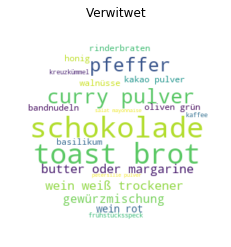

In [171]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
wc = WordCloud(background_color="white",width=2000,height=2000, max_words=21,mask=mask,relative_scaling=0.7,normalize_plurals=False).generate_from_frequencies(dictionary)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title('Verwitwet')
plt.show()

In [174]:
dictionary = {k: v for k, v in sorted(dict_vergeben.items(), key=lambda item: -item[1])}